In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy import interpolate
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [2]:
trips = pd.read_csv("data/Trips_by_Distance.csv")
epicurve_report_date = pd.read_csv("data/epicurve_rpt_date.csv")

C:\Users\Matt\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (3,5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [189]:
trip_indices = np.array(trips["State Postal Code"] == "GA")
trip_indices = np.logical_and(trip_indices, np.array(pd.to_datetime(trips["Date"]) >= "2020-02-29"))
state_travel = trips.loc[trip_indices].reset_index()
trip_indices = np.where(pd.isnull(state_travel["County Name"]))
state_travel = state_travel.loc[trip_indices]

state_travelers = state_travel["Population Not Staying at Home"]
state_population = (state_travel["Population Staying at Home"] + state_travelers).iloc[0]
state_trip_dates = pd.to_datetime(state_travel["Date"])

case_indices = np.logical_and(np.array(epicurve_report_date["county"] == "Georgia"), np.array(epicurve_report_date["report_date"] <= "2021-04-10"))
case_indices = np.logical_and(case_indices, np.array(epicurve_report_date["report_date"] >= "2020-02-29"))
state_cases = epicurve_report_date.loc[case_indices].reset_index()

state_case_dates = pd.to_datetime(state_cases["report_date"])
state_case_numbers = state_cases["total_cases"]
state_case_cum = state_cases["total_cases_cum"]
state_case_ma = state_cases["moving_avg_total_cases"]
state_death_numbers = state_cases["deaths"]
state_death_cum = state_cases["death_cum"]
state_death_ma = state_cases["moving_avg_deaths"]

state_travel_frac = state_travelers/state_population

state_case_frac = 1e5*state_case_numbers/state_population
state_death_frac = 1e5*state_death_numbers/state_population

state_case_cum_frac = 1e5*state_case_cum/state_population
state_death_cum_frac = 1e5*state_death_cum/state_population

state_case_ma_frac = 1e5*state_case_ma/state_population
state_death_ma_frac = 1e5*state_death_ma/state_population

feature_labels = ["Cases per 100k", "Cumulative Cases per 100k", "Moving Average Cases per 100k",
                  "Deaths per 100k", "Cumulative Deaths per 100k", "Moving Average Deaths per 100k"]
state_X = pd.concat([state_case_frac, state_case_cum_frac, state_case_ma_frac,
                     state_death_frac, state_death_cum_frac, state_death_ma_frac],axis=1)
state_y = state_travel_frac

In [190]:
def feature_extraction(county_name):
    trip_indices = np.logical_and(np.array(trips["County Name"] == (county_name + " County")), np.array(trips["State Postal Code"] == "GA"))
    trip_indices = np.logical_and(trip_indices, np.array(pd.to_datetime(trips["Date"]) >= "2020-02-29"))
    county_travel = trips.loc[trip_indices].reset_index()
    
    county_travelers = county_travel["Population Not Staying at Home"]
    county_population = (county_travel["Population Staying at Home"] + county_travelers).iloc[0]
    county_trip_dates = pd.to_datetime(county_travel["Date"])
    
    case_indices = np.logical_and(np.array(epicurve_report_date["county"] == county_name), np.array(epicurve_report_date["report_date"] <= "2021-04-10"))
    case_indices = np.logical_and(case_indices, np.array(epicurve_report_date["report_date"] >= "2020-02-29"))
    county_cases = epicurve_report_date.loc[case_indices].reset_index()
    
    county_case_dates = pd.to_datetime(county_cases["report_date"])
    county_case_numbers = county_cases["total_cases"]
    county_case_cum = county_cases["total_cases_cum"]
    county_case_ma = county_cases["moving_avg_total_cases"]
    county_death_numbers = county_cases["deaths"]
    county_death_cum = county_cases["death_cum"]
    county_death_ma = county_cases["moving_avg_deaths"]
    
    county_travel_frac = county_travelers/county_population
    
    county_case_frac = 1e5*county_case_numbers/county_population
    county_death_frac = 1e5*county_death_numbers/county_population
    
    county_case_cum_frac = 1e5*county_case_cum/county_population
    county_death_cum_frac = 1e5*county_death_cum/county_population
    
    county_case_ma_frac = 1e5*county_case_ma/county_population
    county_death_ma_frac = 1e5*county_death_ma/county_population
    
    feature_labels = ["Cases per 100k", "Cumulative Cases per 100k", "Moving Average Cases per 100k",
                      "Deaths per 100k", "Cumulative Deaths per 100k", "Moving Average Deaths per 100k"]
    feature_matrix = pd.concat([county_case_frac, county_case_cum_frac, county_case_ma_frac,
                                county_death_frac, county_death_cum_frac, county_death_ma_frac],axis=1)
    return county_trip_dates, county_travel_frac, feature_matrix, feature_labels

In [203]:
def spline_wrapper(county_X, county_y, field, field_name, smoothing):
    selected_column = county_X[field]
    selected_column = np.array(selected_column).reshape(len(selected_column),1)
    y = county_y
    y = np.array(y).reshape(len(y),1)
    combined = np.concatenate([selected_column,y],axis=1)
    combined = combined[combined[:,0].argsort()]

    selected_column = combined[:,0]
    y = combined[:,1]

    spline = interpolate.UnivariateSpline(selected_column,y,s=smoothing)
    x_range = np.linspace(min(selected_column),max(selected_column),100)
    new_Y = spline(x_range)

    fig = plt.subplots(figsize=(15,6))

    plt.plot(x_range, new_Y,color='red')
    plt.scatter(selected_column,y,color='k',s=8)

    plt.xlabel(field_name,fontsize=14,labelpad=10)
    plt.ylabel("Fraction Travelers",fontsize=14,labelpad=12)

    plt.show()

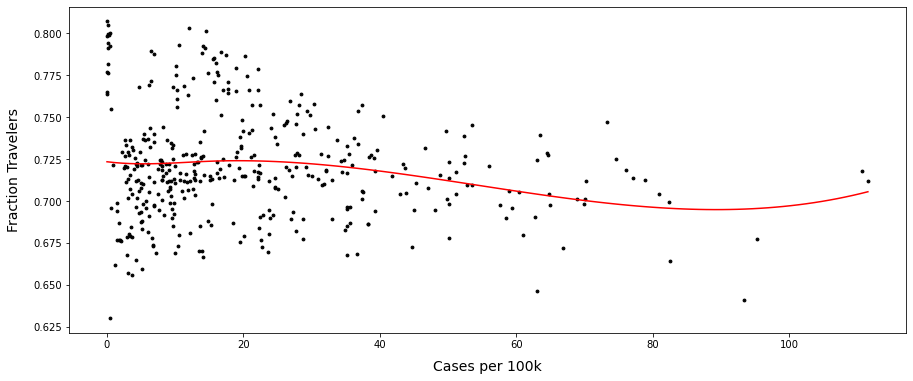

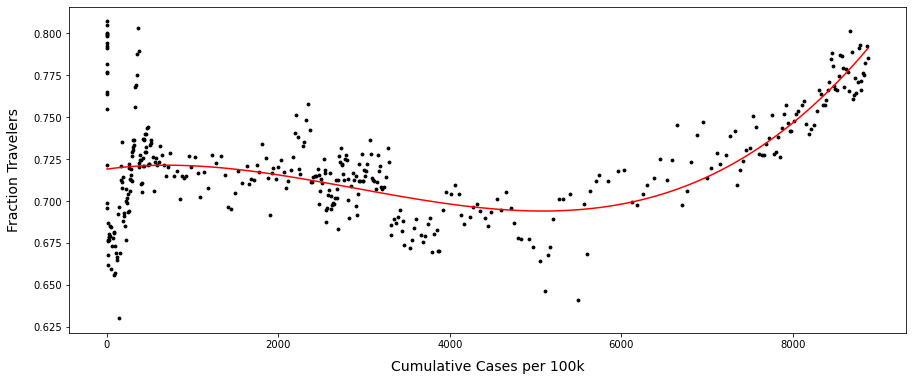

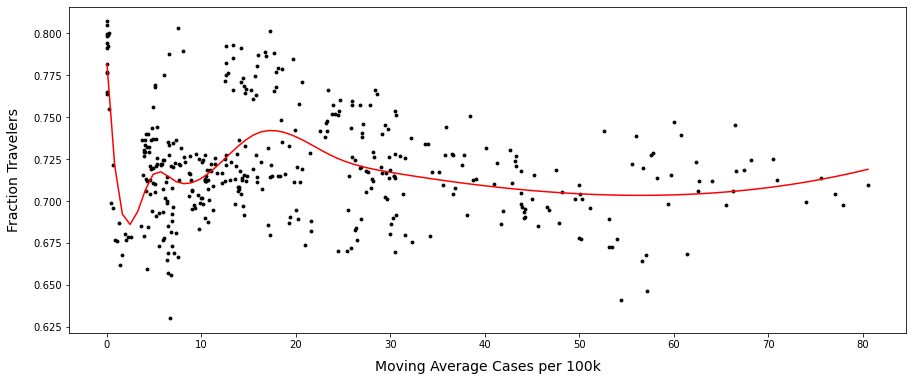

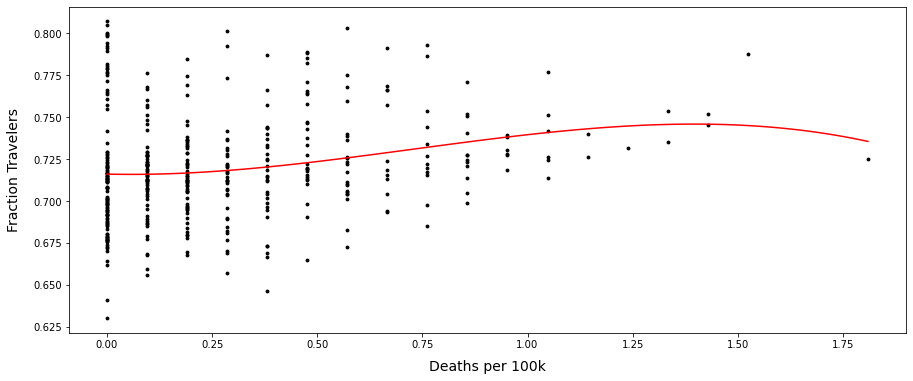

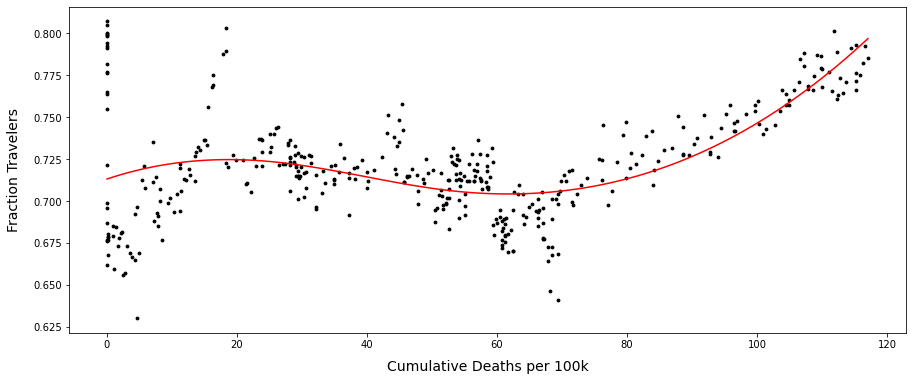

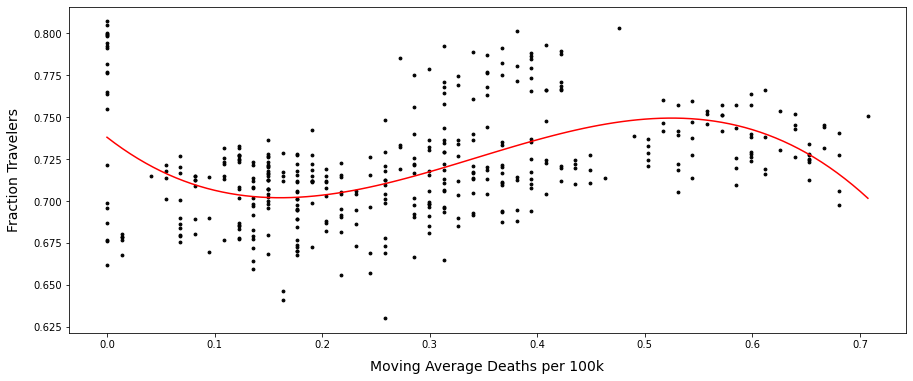

In [218]:
dates, fulton_y, fulton_X, feature_labels = feature_extraction("Fulton")
fulton_smoothing = [0.4,0.3,0.3,0.5,0.25,0.5]
for i in range(len(fulton_X.columns)):
    spline_wrapper(fulton_X, fulton_y, fulton_X.columns[i], feature_labels[i], smoothing=fulton_smoothing[i])

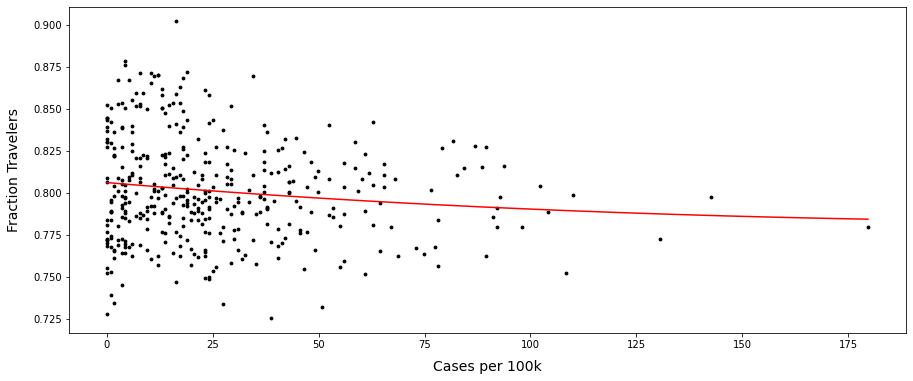

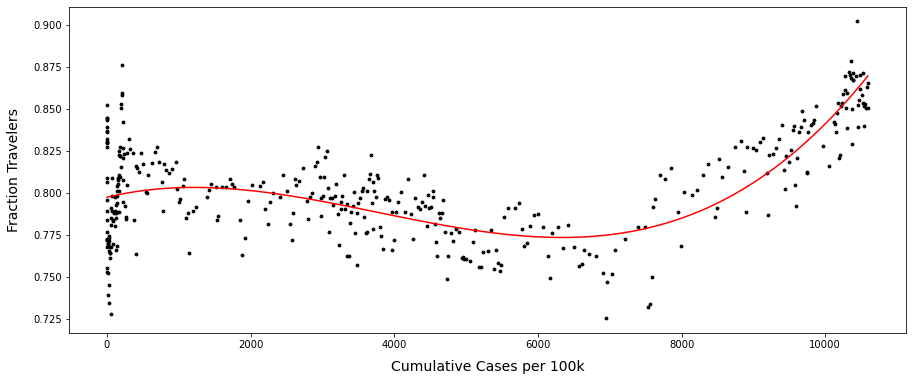

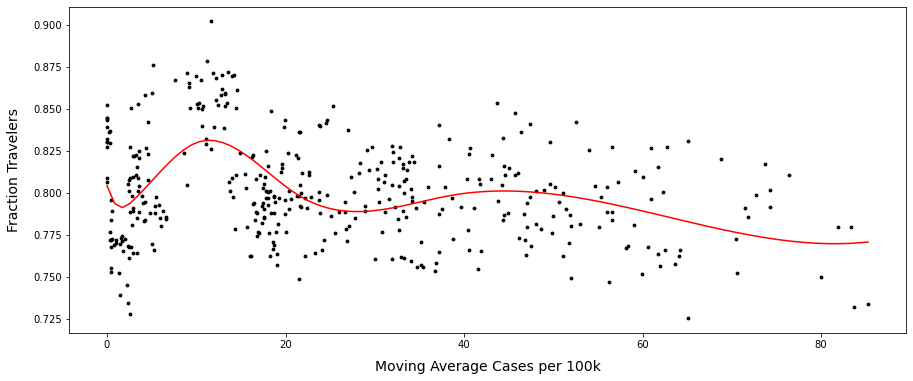

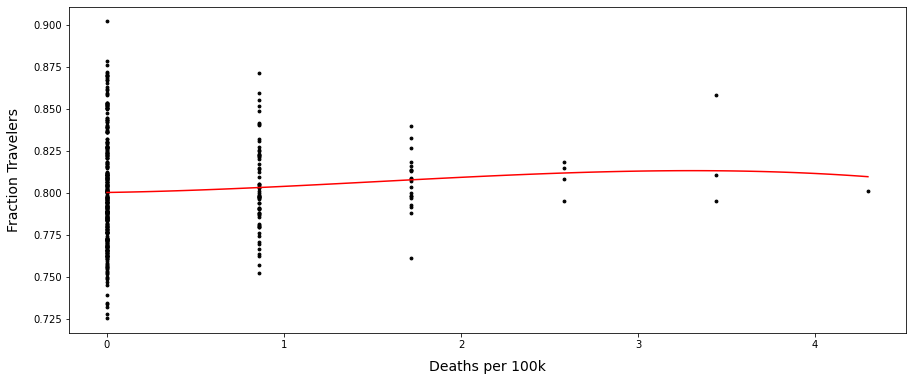

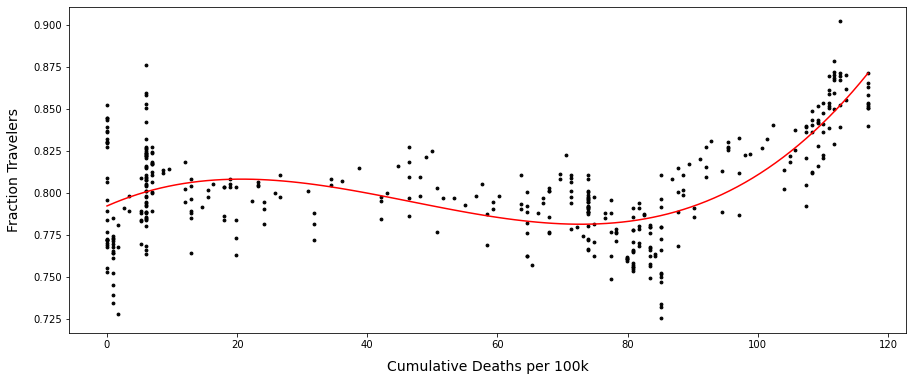

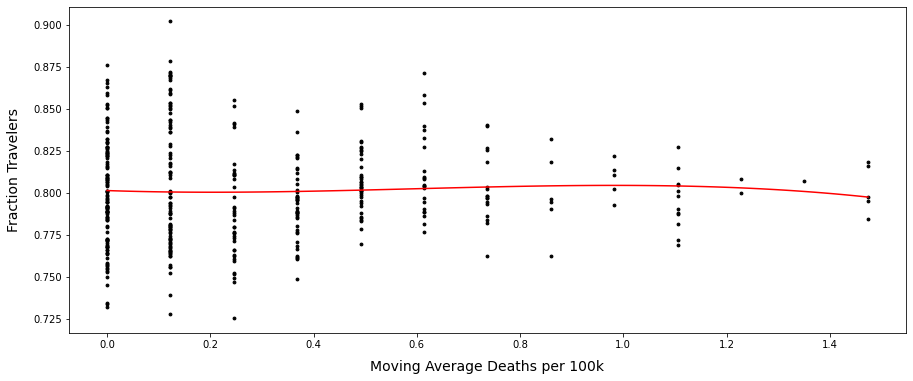

In [221]:
dates, lowndes_y, lowndes_X, feature_labels = feature_extraction("Lowndes")
lowndes_smoothing = [0.4,0.3,0.3,0.5,0.25,0.5]
for i in range(len(lowndes_X.columns)):
    spline_wrapper(lowndes_X, lowndes_y, lowndes_X.columns[i], feature_labels[i], smoothing=lowndes_smoothing[i])

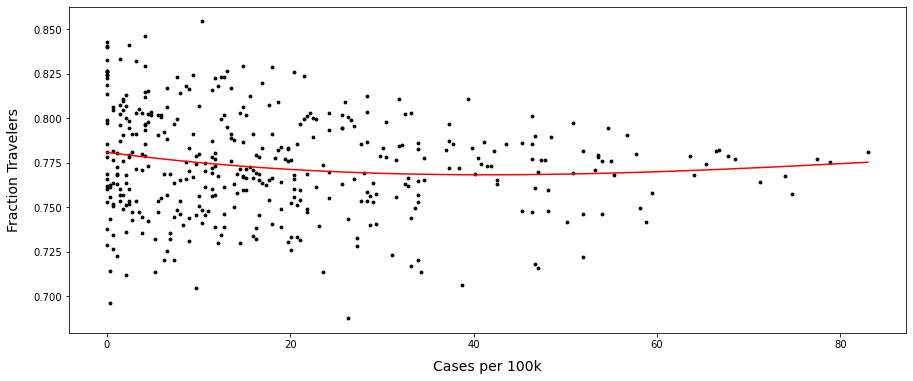

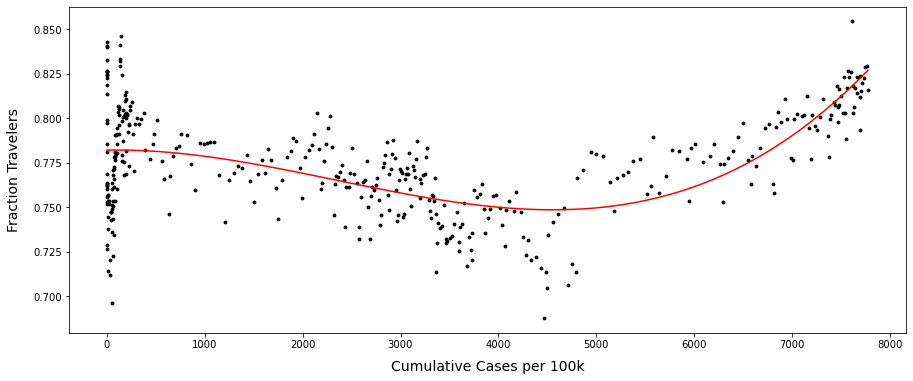

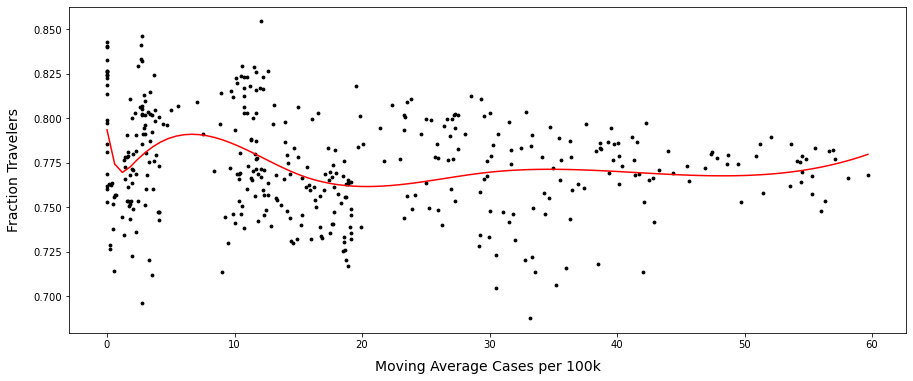

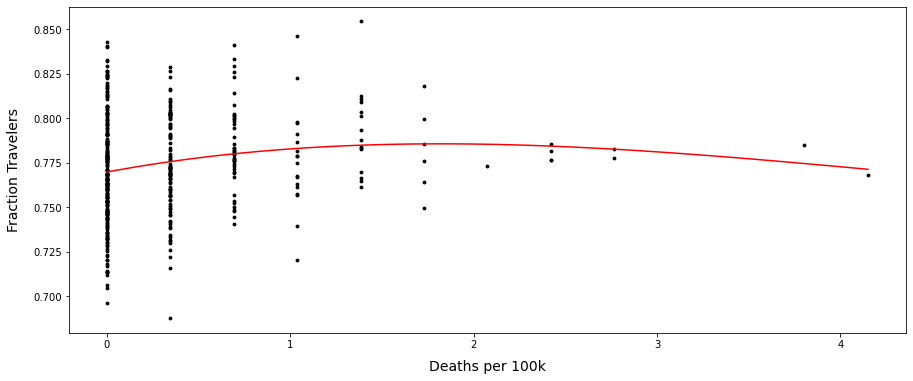

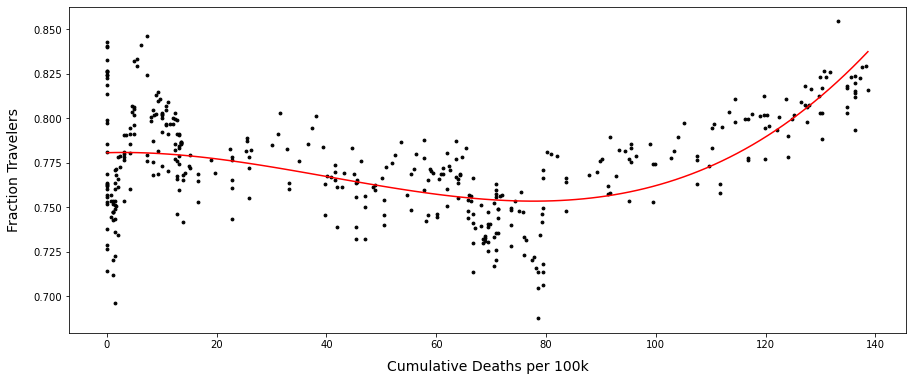

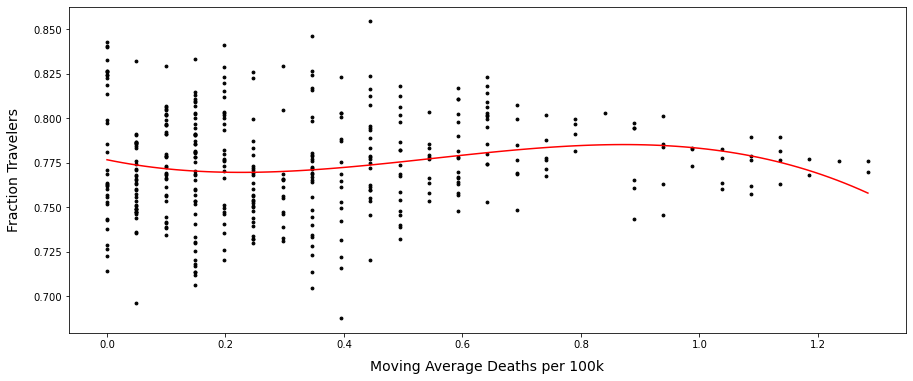

In [222]:
dates, chatham_y, chatham_X, feature_labels = feature_extraction("Chatham")
chatham_smoothing = [0.4,0.3,0.3,0.5,0.25,0.5]
for i in range(len(chatham_X.columns)):
    spline_wrapper(chatham_X, chatham_y, chatham_X.columns[i], feature_labels[i], smoothing=chatham_smoothing[i])

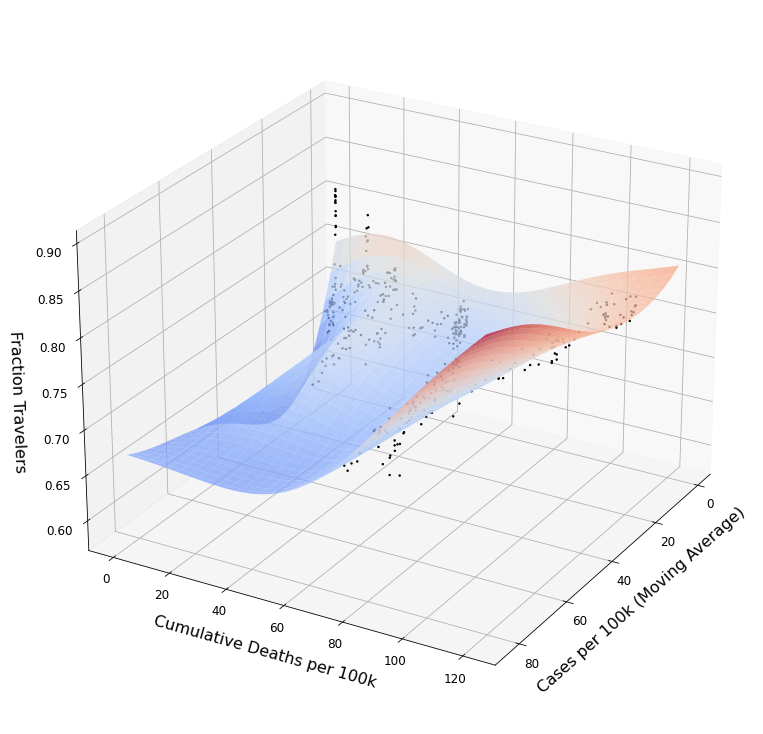

In [194]:
spline = interpolate.Rbf(fulton_X["moving_avg_total_cases"]/max(fulton_X["moving_avg_total_cases"]),
                         fulton_X["death_cum"]/max(fulton_X["death_cum"]),
                         fulton_y,smooth=.01,epsilon=.5)

x1_range = np.arange(0,1.05,0.01)
x2_range = np.arange(0,1.05,0.01)
x1_range, x2_range = np.meshgrid(x1_range, x2_range, indexing='xy')

new_Z = spline(x1_range, x2_range)

fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)

ax.plot_surface(x1_range * max(fulton_X["moving_avg_total_cases"]), x2_range * max(fulton_X["death_cum"]),
                new_Z, cmap=cm.coolwarm, linewidth=0, antialiased=True,alpha=0.75)
ax.scatter(fulton_X["moving_avg_total_cases"],fulton_X["death_cum"],fulton_y,s=2,color='k',alpha=1)

ax.set_xlabel("Cases per 100k (Moving Average)",fontsize=16,labelpad=10)
ax.set_ylabel("Cumulative Deaths per 100k",fontsize=16,labelpad=12)
ax.set_zlabel("Fraction Travelers",fontsize=16,labelpad=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(12)
ax.tick_params(axis='z', which='major', pad=8)

ax.elev = 25
ax.azim = 30
plt.show()